# US Production Data for RBC Modeling

In [1]:
import pandas as pd
import numpy as np
import fredpy as fp
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
pd.plotting.register_matplotlib_converters()

In [2]:
# Load API key
fp.api_key = fp.load_api_key('fred_api_key.txt')

# Download nominal GDP, nominal personal consumption expenditures, nominal
# gross private domestic investment, the GDP deflator, and an index of hours 
# worked in the nonfarm business sector produced by the BLS. All data are
# from FRED and are quarterly.
gdp = fp.series('GDP')
cons = fp.series('PCEC')
invest = fp.series('GPDI')
hours = fp.series('HOANBS')
defl = fp.series('GDPDEF')
pcec = fp.series('PCEC')
m2 = fp.series('M2SL')
tb3mo = fp.series('TB3MS')
unemp = fp.series('UNRATE')

# Convert monthly M2, 3-mo T-Bill, and unemployment to quarterly
m2 = m2.as_frequency('Q')
tb3mo = tb3mo.as_frequency('Q')
unemp = unemp.as_frequency('Q')

# Convert unemployment and t-bill data to decimals instead of percents
unemp.data = unemp.data/100
tb3mo.data = tb3mo.data/100

# pcec inflation as pecent change over past year
pcec = pcec.apc()
pcec.data = pcec.data/100

# Make sure that all of the downloaded series have the same data ranges
gdp,cons,invest,hours,defl,pcec,m2,tb3mo,unemp = fp.window_equalize([gdp,cons,invest,hours,defl,pcec,m2,tb3mo,unemp])

# Compute real GDP, real consumption, real investment
gdp.data = gdp.data/defl.data*100
cons.data = cons.data/defl.data*100
invest.data = invest.data/defl.data*100
m2.data = m2.data/defl.data*100


# Print units
print('Hours units:   ',hours.units)
print('Deflator units:',defl.units)

Hours units:    Index 2012=100
Deflator units: Index 2012=100


Next, compute the quarterly capital stock series for the US using the perpetual inventory method. The discrete-time Solow growth model is given by:

\begin{align}
Y_t & = A_tK_t^{\alpha}L_t^{1-\alpha} \tag{1}\\
C_t & = (1-s)Y_t \tag{2}\\
Y_t & = C_t + I_t \tag{3}\\
K_{t+1} & = I_t + (1-\delta)K_t \tag{4}\\
A_{t+1} & = (1+g)A_t \tag{5}\\
L_{t+1} & = (1+n)L_t \tag{6}.
\end{align}

Here the model is assumed to be quarterly so $n$ is the *quarterly* growth rate of labor hours, $g$ is the *quarterly* growth rate of TFP, and $\delta$ is the *quarterly* rate of depreciation of the capital stock. Given a value of the quarterly depreciation rate $\delta$, an investment series $I_t$, and an initial capital stock $K_0$, the law of motion for the capital stock, Equation (4), can be used to compute an implied capital series. But we don't know $K_0$ or $\delta$ so we'll have to *calibrate* these values using statistics computed from the data that we've already obtained.

Let lowercase letters denote a variable that's been divided by $A_t^{1/(1-\alpha)}L_t$. E.g.,

\begin{align}
y_t = \frac{Y_t}{A_t^{1/(1-\alpha)}L_t}\tag{7}
\end{align}

Then (after substituting consumption from the model), the scaled version of the model can be written as: 

\begin{align}
y_t & = k_t^{\alpha} \tag{8}\\
i_t & = sy_t \tag{9}\\
k_{t+1} & = i_t + (1-\delta-n-g')k_t,\tag{10}
\end{align}

where $g' = g/(1-\alpha)$ is the growth rate of $A_t^{1/(1-\alpha)}$. In the steady state:

\begin{align}
k & = \left(\frac{s}{\delta+n+g'}\right)^{\frac{1}{1-\alpha}} \tag{11}
\end{align}

which means that the ratio of capital to output is constant:

\begin{align}
\frac{k}{y} & = \frac{s}{\delta+n+g'} \tag{12}
\end{align}

and therefore the steady state ratio of depreciation to output is:

\begin{align}
\overline{\delta K/ Y} & = \frac{\delta s}{\delta + n + g'} \tag{13}
\end{align}

where $\overline{\delta K/ Y}$ is the long-run average ratio of depreciation to output. We can use Equation (13) to calibrate $\delta$ given $\overline{\delta K/ Y}$, $s$, $n$, and $g'$.

Furthermore, in the steady state, the growth rate of output is constant:

\begin{align}
\frac{\Delta Y}{Y} & = n + g' \tag{14}
\end{align} 


1. Assume $\alpha = 0.35$.
2. Calibrate $s$ as the average of ratio of investment to GDP.
3. Calibrate $n$ as the average quarterly growth rate of labor hours.
4. Calibrate $g'$ as the average quarterly growth rate of real GDP minus n.
5. Calculate the average ratio of depreciation to GDP $\overline{\delta K/ Y}$ and use the result to calibrate $\delta$. That is, find the average ratio of Current-Cost Depreciation of Fixed Assets (FRED series ID: M1TTOTL1ES000) to GDP (FRED series ID: GDPA). Then calibrate $\delta$ from the following steady state relationship:
\begin{align}
\delta & = \frac{\left( \overline{\delta K/ Y} \right)\left(n + g' \right)}{s - \left( \overline{\delta K/ Y} \right)} \tag{15}
\end{align}
6. Calibrate $K_0$ by asusming that the capital stock is initially equal to its steady state value:
\begin{align}
K_0 & = \left(\frac{s}{\delta + n + g'}\right) Y_0 \tag{16}
\end{align}

Then, armed with calibrated values for $K_0$ and $\delta$, compute $K_1, K_2, \ldots$ recursively. See Timothy Kehoe's notes for more information on the perpetual inventory method:

http://users.econ.umn.edu/~tkehoe/classes/GrowthAccountingNotes.pdf



Avg saving rate:         0.17485
Avg annual labor growth: 0.0098
Avg annual gdp growth:   0.01265
Avg annual dep rate:     0.10418


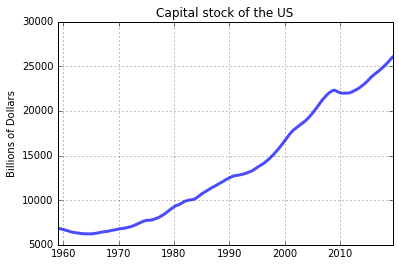

In [3]:
# Set the capital share of income
alpha = 0.35

# Average saving rate
s = np.mean(invest.data/gdp.data)

# Average quarterly labor hours growth rate
n = (hours.data[-1]/hours.data[0])**(1/(len(hours.data)-1)) - 1

# Average quarterly real GDP growth rate
g = ((gdp.data[-1]/gdp.data[0])**(1/(len(gdp.data)-1)) - 1) - n

# Compute annual depreciation rate
depA = fp.series('M1TTOTL1ES000')
gdpA = fp.series('gdpa')

gdpA = gdpA.window([gdp.data.index[0],gdp.data.index[-1]])
gdpA,depA = fp.window_equalize([gdpA,depA])

deltaKY = np.mean(depA.data/gdpA.data)
delta = (n+g)*deltaKY/(s-deltaKY)

# print calibrated values:
print('Avg saving rate:        ',round(s,5))
print('Avg annual labor growth:',round(4*n,5))
print('Avg annual gdp growth:  ',round(4*g,5))
print('Avg annual dep rate:    ',round(4*delta,5))

# Construct the capital series. Note that the GPD and investment data are reported on an annualized basis
# so divide by 4 to get quarterly data.
capital = np.zeros(len(gdp.data))
capital[0] = gdp.data[0]/4*s/(n+g+delta)

for t in range(len(gdp.data)-1):
    capital[t+1] = invest.data[t]/4 + (1-delta)*capital[t]

# Save in a fredpy series
capital = fp.to_fred_series(data = capital,dates =gdp.data.index,units = gdp.units,title='Capital stock of the US',frequency='Quarterly')
# plot the computed capital series
plt.plot(capital.data.index,capital.data,'-',lw=3,alpha = 0.7)
plt.ylabel(capital.units)
plt.title(capital.title)
plt.grid()

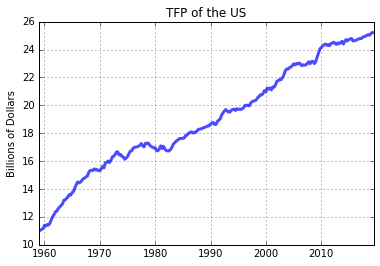

In [4]:
# Compute TFP
tfp = gdp.data/capital.data**alpha/hours.data**(1-alpha)
tfp = fp.to_fred_series(data = tfp,dates =gdp.data.index,units = gdp.units,title='TFP of the US',frequency='Quarterly')

# Plot the computed capital series
plt.plot(tfp.data.index,tfp.data,'-',lw=3,alpha = 0.7)
plt.ylabel(tfp.units)
plt.title(tfp.title)
plt.grid()

In [5]:
# Convert each series into per capita using civilian pop 16 and over
gdp = gdp.per_capita(civ_pop=True)
cons = cons.per_capita(civ_pop=True)
invest = invest.per_capita(civ_pop=True)
hours = hours.per_capita(civ_pop=True)
capital = capital.per_capita(civ_pop=True)
m2 = m2.per_capita(civ_pop=True)

# Put GDP, consumption, investment, and M2 in units of thousands of dollars per person
gdp.data = gdp.data*1000
cons.data = cons.data*1000
invest.data = invest.data*1000
capital.data = capital.data*1000
m2.data = m2.data/1000

# Scale hours per person to equal 100 on October (Quarter III) of 2012 
hours.data = hours.data/hours.data.loc['2012-10-01']*100

# Compute and plot log real GDP, log consumption, log investment, log hours
gdp_log = gdp.log()
cons_log = cons.log()
invest_log = invest.log()
hours_log = hours.log()
capital_log = capital.log()
tfp_log = tfp.log()
m2_log = m2.log()
m2_log = m2.log()

In [6]:
# HP filter to isolate trend and cyclical components
gdp_log_cycle,gdp_log_trend = gdp_log.hp_filter()
cons_log_cycle,cons_log_trend = cons_log.hp_filter()
invest_log_cycle,invest_log_trend = invest_log.hp_filter()
hours_log_cycle,hours_log_trend = hours_log.hp_filter()
capital_log_cycle,capital_log_trend = capital_log.hp_filter()
tfp_log_cycle,tfp_log_trend = tfp_log.hp_filter()
m2_log_cycle,m2_log_trend = m2_log.hp_filter()
tb3mo_cycle,tb3mo_trend = tb3mo.hp_filter()
unemp_cycle,unemp_trend = unemp.hp_filter()
pcec_cycle,pcec_trend = pcec.hp_filter()

In [7]:
# Create a DataFrame with actual and trend data
data = pd.DataFrame({
        'gdp':gdp.data,
        'gdp_trend':np.exp(gdp_log_trend.data),
        'gdp_cycle':gdp_log_cycle.data,
        'consumption':cons.data,
        'consumption_trend':np.exp(cons_log_trend.data),
        'consumption_cycle':cons_log_cycle.data,
        'investment':invest.data,
        'investment_trend':np.exp(invest_log_trend.data),
        'investment_cycle':invest_log_cycle.data,
        'hours':hours.data,
        'hours_trend':np.exp(hours_log_trend.data),
        'hours_cycle':hours_log_cycle.data,
        'capital':capital.data,
        'capital_trend':np.exp(capital_log_trend.data),
        'capital_cycle':capital_log_cycle.data,
        'tfp':tfp.data,
        'tfp_trend':np.exp(tfp_log_trend.data),
        'tfp_cycle':tfp_log_cycle.data,
        'real_m2':m2.data,
        'real_m2_trend':np.exp(m2_log_trend.data),
        'real_m2_cycle':m2_log_cycle.data,
        't_bill_3mo':tb3mo.data,
        't_bill_3mo_trend':tb3mo_trend.data,
        't_bill_3mo_cycle':tb3mo_cycle.data,
        'pce_inflation':pcec.data,
        'pce_inflation_trend':pcec_trend.data,
        'pce_inflation_cycle':pcec_cycle.data,
        'unemployment':unemp.data,
        'unemployment_trend':unemp_trend.data,
        'unemployment_cycle':unemp_cycle.data,
    },index = gdp.data.index)


# # RBC Data
# columns_ordered =[]
# names = ['gdp','consumption','investment','hours','capital','tfp']
# for name in names:
#     columns_ordered.append(name)
#     columns_ordered.append(name+'_trend')

# data[columns_ordered].to_csv('../Csv/rbc_data_actual_trend.csv')


# # Create a DataFrame with actual, trend, and cycle data
# columns_ordered =[]
# names = ['gdp','consumption','investment','hours','capital','tfp']
# for name in names:
#     columns_ordered.append(name)
#     columns_ordered.append(name+'_trend')
#     columns_ordered.append(name+'_cycle')
    
# data[columns_ordered].to_csv('../Csv/rbc_data_actual_trend_cycle.csv')


# Business Cycle Data
columns_ordered =[]
names = ['gdp','consumption','investment','hours','capital','tfp','real_m2','t_bill_3mo','pce_inflation','unemployment']
for name in names:
    columns_ordered.append(name)
    columns_ordered.append(name+'_trend')

data[columns_ordered].to_csv('../Csv/business_cycle_data_actual_trend.csv')


# Create a DataFrame with actual, trend, and cycle data
columns_ordered =[]
names = ['gdp','consumption','investment','hours','capital','tfp','real_m2','t_bill_3mo','pce_inflation','unemployment']
for name in names:
    columns_ordered.append(name)
    columns_ordered.append(name+'_trend')
    columns_ordered.append(name+'_cycle')
    
data[columns_ordered].to_csv('../Csv/business_cycle_data_actual_trend_cycle.csv')